## Self-driving Car Project 5: Vehicle Detection and Tracking

In [1]:
# Import libraries
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from mpl_toolkits.mplot3d import Axes3D
import glob
%matplotlib inline
import time

# Libaries for video 
from moviepy.editor import VideoFileClip
from IPython.display import HTML

# Libaries for machine learning
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from skimage.feature import hog
from sklearn.cross_validation import train_test_split
from sklearn.preprocessing import StandardScaler
from skimage.feature import blob_dog, blob_log, blob_doh
from scipy.ndimage.measurements import label


## 0. Load data

### Load image directory

In [2]:
# prepare cars training set
cars_train = []
notcars_train = []

images = glob.glob('/Users/daruizhang/Documents/vehicles/KITTI_extracted/*.png') # cars
for image in images:
    cars_train.append(image)

images = glob.glob('/Users/daruizhang/Documents/non-vehicles/Extras/*.png') # noncars
for image in images:
    notcars_train.append(image)


In [3]:
# prepare test set image from a different folder
cars_test = []
notcars_test = []

# car
images = glob.glob('/Users/daruizhang/Documents/vehicles/GTI_Far/*.png') # cars
for image in images:
    cars_test.append(image)

images = glob.glob('/Users/daruizhang/Documents/vehicles/GTI_Left/*.png') # cars
for image in images:
    cars_test.append(image)

images = glob.glob('/Users/daruizhang/Documents/vehicles/GTI_MiddleClose/*.png') # cars
for image in images:
    cars_test.append(image)

images = glob.glob('/Users/daruizhang/Documents/vehicles/GTI_Right/*.png') # cars
for image in images:
    cars_test.append(image)

# noncar
images = glob.glob('/Users/daruizhang/Documents/non-vehicles/GTI/*.png') # noncars
for image in images:
    notcars_test.append(image)

### Data summary

In [16]:
# Define a function to return some characteristics of the dataset 
def data_look(car_list, notcar_list):
    data_dict = {}
    # Define a key in data_dict "n_cars" and store the number of car images
    data_dict["n_cars"] = len(car_list)
    # Define a key "n_notcars" and store the number of notcar images
    data_dict["n_notcars"] = len(notcar_list)
    # Read in a test image, either car or notcar
    example_img = mpimg.imread(car_list[0])
    # Define a key "image_shape" and store the test image shape 3-tuple
    data_dict["image_shape"] = example_img.shape
    # Define a key "data_type" and store the data type of the test image.
    data_dict["data_type"] = example_img.dtype
    # Return data_dict
    return data_dict

Car images:     5766
Non-car images: 5766
Image size:     (64, 64, 3)
Data type:      float32


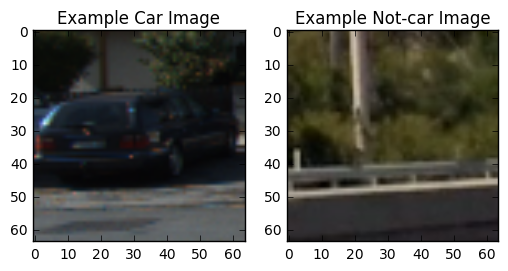

In [17]:
# Basic data summary
data_info = data_look(cars_train, notcars_train)
print('Car images:    ', data_info["n_cars"])
print('Non-car images:', data_info["n_notcars"])
print('Image size:    ', data_info["image_shape"])
print('Data type:     ', data_info["data_type"])


# Just for fun choose random car / not-car indices and plot example images   
car_ind = np.random.randint(0, len(cars_train))
notcar_ind = np.random.randint(0, len(notcars_train))
    
# Read in car / not-car images
car_image = mpimg.imread(cars_train[car_ind])
noncar_image = mpimg.imread(notcars_train[notcar_ind])


# Plot the examples
fig = plt.figure()
plt.subplot(121)
plt.imshow(car_image)
plt.title('Example Car Image')
plt.subplot(122)
plt.imshow(noncar_image)
plt.title('Example Not-car Image')

## 1. Define Features

### Convert image data type

In [18]:
image_rgb = np.uint8(car_image*255)# convert to 255

### Spatial features

In [19]:
# Define a function to compute binned color features  
def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    spatial_features = cv2.resize(img, size).ravel() 
    # Return the feature vector
    return spatial_features 

Spatial features size: (64,)


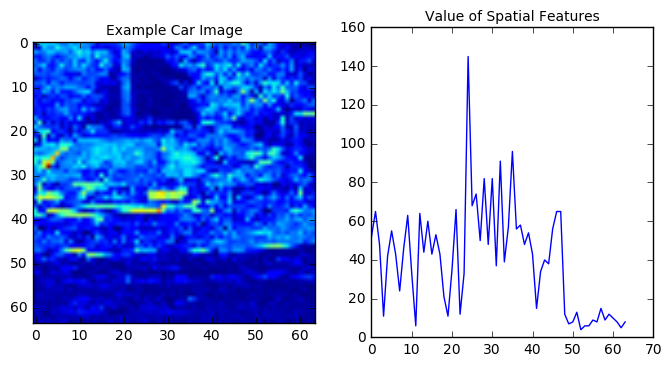

In [253]:
# test if the funtion works
# set tuning parameters
spatial = 8

image_hls = cv2.cvtColor(image_rgb, cv2.COLOR_RGB2HLS) # convert it to HLS
# extract spatial features
# work on the saturation channel
spatial_s = bin_spatial(image_hls[:,:,2], size=(spatial, spatial))

print('Spatial features size:', spatial_s.shape)

# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(8,4))
ax1.imshow(image_hls[:,:,2])
ax1.set_title('Example Car Image', fontsize=10)
ax2.plot(spatial_s)
ax2.set_title('Value of Spatial Features', fontsize=10)


### Color Histogram Features

In [21]:
def color_hist(img, nbins=32, bins_range=(0, 256),hist_vec=True):
    # Compute the histogram of the RGB channels separately
    hist1 = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    hist2 = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    hist3 = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Generating bin centers
    bin_edges = hist1[1]
    bin_centers = (bin_edges[1:]  + bin_edges[0:len(bin_edges)-1])/2
    
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((hist1[0], hist2[0], hist3[0]))
    
    if hist_vec == False:
        # Return the individual histograms, bin_centers and feature vector    
        return hist1, hist2, hist3, bin_centers, hist_features
    else:
        # only return feature vector
        return hist_features

color hist features size: (48,)


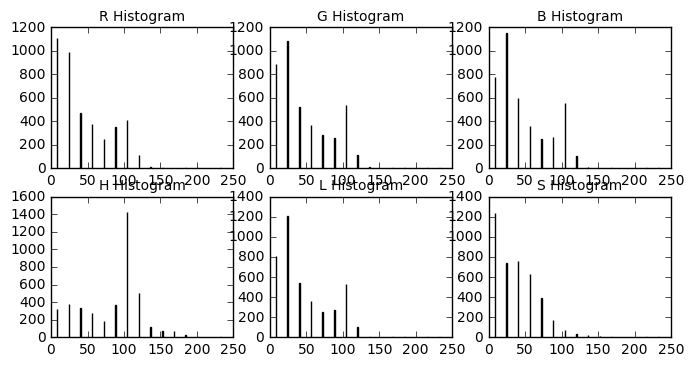

In [22]:
# set tunning parameter
histbin = 16 #number of bins

rh, gh, bh, bincen, hist_rgb = color_hist(image_rgb, nbins=histbin,
                                              bins_range=(0, 256),hist_vec=False)
hh, lh, sh, bincen, hist_hls = color_hist(image_hls, nbins=histbin,
                                              bins_range=(0, 256),hist_vec=False)

print('color hist features size:', hist_rgb.shape)

# Visualize histogram
f, ((ax1, ax2,ax3),(ax4, ax5,ax6) )= plt.subplots(2, 3, figsize=(8,4))

ax1.bar(bincen, rh[0])
ax1.set_title('R Histogram', fontsize=10)

ax2.bar(bincen, gh[0])
ax2.set_title('G Histogram', fontsize=10)


ax3.bar(bincen, bh[0])
ax3.set_title('B Histogram', fontsize=10)

ax4.bar(bincen, hh[0])
ax4.set_title('H Histogram', fontsize=10)

ax5.bar(bincen, lh[0])
ax5.set_title('L Histogram', fontsize=10)

ax6.bar(bincen, sh[0])
ax6.set_title('S Histogram', fontsize=10)


### HOG feature

In [23]:
# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)
        return features

Hog features shape: (4, 4, 2, 2, 8)
Flatterned Hog features size: (512,)


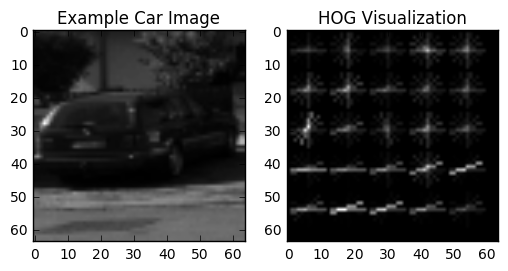

In [279]:
# test if the feature work
image_gray = cv2.cvtColor(image_rgb, cv2.COLOR_RGB2GRAY) # convert to gray scale
# work on grey scale image

# Define HOG parameters
orient = 8
pix_per_cell = 12
cell_per_block = 2

# Call our function with vis=True to see an image output, 
# feature_vec=False to get the feature dimension
hog_features, hog_image = get_hog_features(image_gray, orient, 
                        pix_per_cell, cell_per_block, 
                        vis=True, feature_vec=False)

# flattern the feature to create the feature vector
hog_1d = np.ravel(hog_features) 

# Plot the examples
fig = plt.figure()
plt.subplot(121)
plt.imshow(image_gray, cmap='gray')
plt.title('Example Car Image')
plt.subplot(122)
plt.imshow(hog_image, cmap='gray')
plt.title('HOG Visualization')

# test the funtion
print('Hog features shape:', hog_features.shape)
print('Flatterned Hog features size:', hog_1d.shape)

### Extract featuress

In [564]:
def extract_features(image_rgb):
    
    spatial = 8 
    hist_bins = 12 # color hist parameters
    # Define HOG parameters
    orient = 8
    pix_per_cell = 12
    cell_per_block = 2
    
    # apply color conversion if other than 'RGB'  
    image_hls = cv2.cvtColor(image_rgb, cv2.COLOR_RGB2HLS)# convert it to HLS
    image_gray = cv2.cvtColor(image_rgb, cv2.COLOR_RGB2GRAY)
        
    # Apply bin_spatial() to get spatial color features
    spatial_hls = bin_spatial(image_hls, size=(spatial, spatial))
    spatial_rgb = bin_spatial(image_rgb, size=(spatial, spatial))
        
    # Apply color_hist() also with a color space option now
    hist_hls = color_hist(image_hls, nbins = hist_bins, 
                          bins_range = (0, 256), hist_vec=True)
    hist_rgb = color_hist(image_rgb, nbins= hist_bins, 
                          bins_range = (0, 256), hist_vec=True)       
        
    # Call get_hog_features() with vis=False, feature_vec=True
    hog_grey = get_hog_features(image_gray, orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        
    #hog_s = get_hog_features(image_hls[:,:,2], orient, 
    #                    pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        
    # Append the new feature vector to the features list
    features = np.concatenate((spatial_hls,spatial_rgb,
                               hist_hls,hist_rgb,
                               hog_grey))
                                        
    
    return features

In [281]:
def features_from_data(imgs):
    # Create a list to append feature vectors to
    features_all = []
    # Iterate through the list of images
    for file in imgs:
        # Read in each one by one
        image = mpimg.imread(file)
        
        image_rgb = np.uint8(image*255)# convert to 255

        features = extract_features(image_rgb) # extract features
        
        features_all.append(features)
    return features_all                  

In [282]:
# extract feature from car images
car_features_train = features_from_data(cars_train)
notcar_features_train = features_from_data(notcars_train)


car_features_test = features_from_data(cars_test)
notcar_features_test = features_from_data(notcars_test)


X_train = np.vstack((car_features_train, notcar_features_train)).astype(np.float32)   
X_test = np.vstack((car_features_test, notcar_features_test)).astype(np.float32)   

print("train    ",X_train.shape)
print("test    ",X_test.shape)


train     (11532, 968)
test     (5652, 968)


### Feature normalization

In [283]:
X_scaler = StandardScaler().fit(X_train)

# Apply the scaler to X
scaled_X_train = X_scaler.transform(X_train)
scaled_X_test = X_scaler.transform(X_test)

In [284]:
y_train = np.hstack((np.ones(len(car_features_train)), np.zeros(len(notcar_features_train))))
y_test = np.hstack((np.ones(len(car_features_test)), np.zeros(len(notcar_features_test))))

In [285]:
print('Training set:', scaled_X_train.shape)
print('Test set    :', scaled_X_test.shape)
print('Training set:', y_train.shape)
print('Test set    :', y_test.shape)

Training set: (11532, 968)
Test set    : (5652, 968)
Training set: (11532,)
Test set    : (5652,)


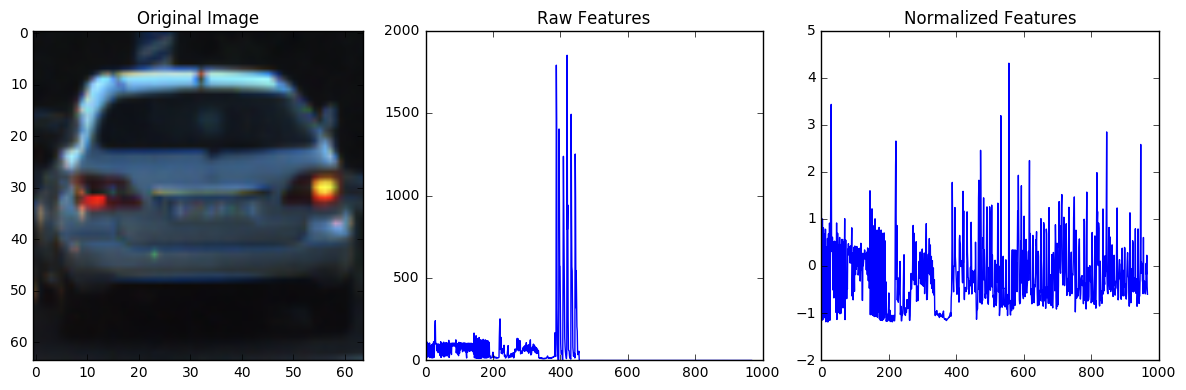

In [286]:
# plot feature normalization
car_ind = np.random.randint(0, len(cars_train))
# Plot an example of raw and scaled features
fig = plt.figure(figsize=(12,4))
plt.subplot(131)
plt.imshow(mpimg.imread(cars_train[car_ind]))
plt.title('Original Image')
plt.subplot(132)
plt.plot(X_train[car_ind])
plt.title('Raw Features')
plt.subplot(133)
plt.plot(scaled_X_train[car_ind])
plt.title('Normalized Features')
fig.tight_layout()

### split trainign and test set

In [287]:
from sklearn.utils import shuffle
X_train, y_train = shuffle( scaled_X_train, y_train, random_state=42)

In [288]:
# Split up data into randomized training and test sets

X_test, X_valid, y_test, y_valid = train_test_split(
    scaled_X_test, y_test, test_size=0.5, random_state=42)

In [289]:
print('Training set:', X_train.shape)
print('Training set:', X_valid.shape)
print('Test set    :', X_test.shape)

Training set: (11532, 968)
Training set: (2826, 968)
Test set    : (2826, 968)


## 2. Define classifier

### Train a classifier

20, min_samples_leaf = 4,max_depth = 6

In [392]:
from sklearn.metrics import roc_auc_score


# max_feature
x = [3,8,15] #7
# max_depth 
y = [2,4,10] #8
# tree leaf
z = [2,4] # 9

for i in x:
    for j in y:
        for k in z:
            print ("ftr: {} ,dpt: {} ,lef: {}".format(i,j,k ))
            clf = RandomForestClassifier(n_estimators = 100,
                                         max_features = i,
                                         max_depth = j,
                                         min_samples_leaf = k,
                                         random_state = 42,) 
            clf.fit(X_train, y_train)
            #predict_labels(clf, X_test, y_test)
            pred = clf.predict_proba(X_valid)[:,1]
            auroc = roc_auc_score(y_valid, pred)
            
            print('auroc = ', round(auroc, 4))

            #print('Validation Accuracy = ', round(clf.score(X_valid, y_valid), 4))


ftr: 10 ,dpt: 2 ,lef: 1
auroc =  0.9602
ftr: 10 ,dpt: 2 ,lef: 3
auroc =  0.9602
ftr: 10 ,dpt: 2 ,lef: 5
auroc =  0.9602
ftr: 10 ,dpt: 4 ,lef: 1
auroc =  0.9593
ftr: 10 ,dpt: 4 ,lef: 3
auroc =  0.9608
ftr: 10 ,dpt: 4 ,lef: 5
auroc =  0.9604
ftr: 10 ,dpt: 20 ,lef: 1
auroc =  0.9573
ftr: 10 ,dpt: 20 ,lef: 3
auroc =  0.9552
ftr: 10 ,dpt: 20 ,lef: 5
auroc =  0.9538
ftr: 10 ,dpt: 24 ,lef: 1
auroc =  0.9554
ftr: 10 ,dpt: 24 ,lef: 3
auroc =  0.9558
ftr: 10 ,dpt: 24 ,lef: 5
auroc =  0.9544
ftr: 20 ,dpt: 2 ,lef: 1
auroc =  0.9403
ftr: 20 ,dpt: 2 ,lef: 3
auroc =  0.9403
ftr: 20 ,dpt: 2 ,lef: 5
auroc =  0.9403
ftr: 20 ,dpt: 4 ,lef: 1
auroc =  0.9411
ftr: 20 ,dpt: 4 ,lef: 3
auroc =  0.9437
ftr: 20 ,dpt: 4 ,lef: 5
auroc =  0.9433
ftr: 20 ,dpt: 20 ,lef: 1
auroc =  0.9371
ftr: 20 ,dpt: 20 ,lef: 3
auroc =  0.9408
ftr: 20 ,dpt: 20 ,lef: 5
auroc =  0.9376
ftr: 20 ,dpt: 24 ,lef: 1
auroc =  0.938
ftr: 20 ,dpt: 24 ,lef: 3
auroc =  0.9415
ftr: 20 ,dpt: 24 ,lef: 5
auroc =  0.937
ftr: 30 ,dpt: 2 ,lef: 1
auroc 

In [560]:
type(X_train)

numpy.ndarray

In [566]:
X_all = np.concatenate((X_train,X_valid,X_test))
y_all = np.concatenate((y_train,y_valid,y_test))


In [556]:
clf = RandomForestClassifier(n_estimators=100, max_features = 3, min_samples_leaf = 4,max_depth = 10)

# Check the training time for the SVC
t=time.time()
clf.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')


pred = clf.predict_proba(X_train)[:,1]
auroc = roc_auc_score(y_train, pred)            
print('auroc = ', round(auroc, 4))

pred = clf.predict_proba(X_valid)[:,1]
auroc = roc_auc_score(y_valid, pred)            
print('auroc = ', round(auroc, 4))


pred = clf.predict_proba(X_test)[:,1]
auroc = roc_auc_score(y_test, pred)            
print('auroc = ', round(auroc, 4))

2.58 Seconds to train SVC...
auroc =  1.0
auroc =  0.9692
auroc =  0.9692


In [567]:
clf.fit(X_all, y_all)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=10, max_features=3, max_leaf_nodes=None,
            min_samples_leaf=4, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

### Test the classifier

## 3.Define Sliding Window

In [504]:
# load test images
img1 = cv2.imread('test_images/test1.jpg')
img2 = cv2.imread('test_images/test2.jpg')
img3 = cv2.imread('test_images/test3.jpg')
img4 = cv2.imread('test_images/test4.jpg')
img5 = cv2.imread('test_images/test5.jpg')
img6 = cv2.imread('test_images/test6.jpg')

### Draw boxes

In [307]:
# draw boxes
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    draw_img = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(draw_img, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return draw_img

In [ ]:
# Here are the bounding boxes I used
bboxes = [((275, 572), (380, 510)), ((488, 563), (549, 518)), ((554, 543), (582, 522)), 
          ((601, 555), (646, 522)), ((657, 545), (685, 517)), ((849, 678), (1135, 512))]

# load an image
img_box = draw_boxes(img1, bboxes, color=(0, 0, 255), thick=6)
plt.imshow(img_box)

### sliding window

In [308]:
# Define a function that takes an image,
# start and stop positions in both x and y, 
# window size (x and y dimensions),  
# and overlap fraction (for both x and y)
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_windows = np.int(xspan/nx_pix_per_step) - 1
    ny_windows = np.int(yspan/ny_pix_per_step) - 1
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list


In [523]:
# the minimum window size
x_min =[350, 1280]
y_min =[400, 530]
xy_min = (80, 80)

# the maxium window size
x_max =[400, 1280]
y_max =[400, 700]
xy_max = (160, 160)

# intermedian windows
n = 4
x = []
y = []
xy =[]
for i in range(n):
    x_start_stop =[int(x_min[0] + i*(x_max[0]-x_min[0])/(n-1)), 
                   int(x_min[1] + i*(x_max[1]-x_min[1])/(n-1))]
    y_start_stop =[int(y_min[0] + i*(y_max[0]-y_min[0])/(n-1)), 
                   int(y_min[1] + i*(y_max[1]-y_min[1])/(n-1))]
    xy_window    =[int(xy_min[0] + i*(xy_max[0]-xy_min[0])/(n-1)), 
                   int(xy_min[1] + i*(xy_max[1]-xy_min[1])/(n-1))]
    x.append(x_start_stop)
    y.append(y_start_stop)
    xy.append(xy_window)
 

[366, 1280]
[400, 586]
[106, 106]


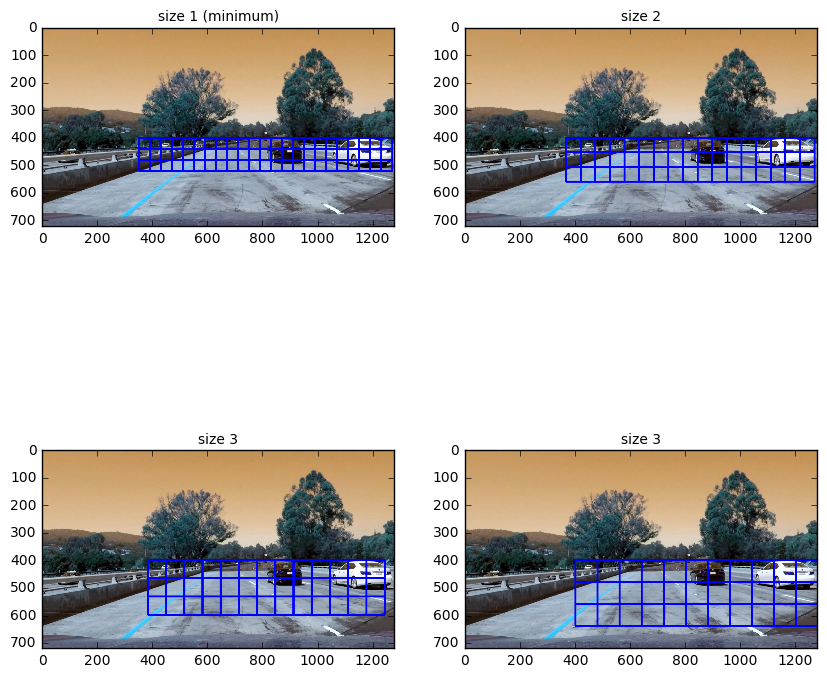

In [529]:
# visualize different window size
x_start_stop = x[1]
y_start_stop = y[1]
xy_window = xy[1]
print(x_start_stop)
print(y_start_stop)
print(xy_window)

windows1 = slide_window(img1, x_start_stop= x[0], y_start_stop = y[0], 
                    xy_window= xy[0], xy_overlap=(0.5, 0.5))
windows2 = slide_window(img1, x_start_stop= x[1], y_start_stop = y[1], 
                    xy_window= xy[1], xy_overlap=(0.5, 0.5))
windows3 = slide_window(img1, x_start_stop= x[2], y_start_stop = y[2], 
                    xy_window= xy[2], xy_overlap=(0.5, 0.5))
windows4 = slide_window(img1, x_start_stop= x[3], y_start_stop = y[3], 
                    xy_window= xy[3], xy_overlap=(0.5, 0.5))

window_img1 = draw_boxes(img1, windows1, color=(0, 0, 255), thick=6)
window_img2 = draw_boxes(img1, windows2, color=(0, 0, 255), thick=6)                    
window_img3 = draw_boxes(img1, windows3, color=(0, 0, 255), thick=6)
window_img4 = draw_boxes(img1, windows4, color=(0, 0, 255), thick=6)


f, ((ax1, ax2),(ax3,ax4)) = plt.subplots(2,2, figsize=(10,10))
ax1.imshow(window_img1)
ax1.set_title('size 1 (minimum)', fontsize=10)
ax2.imshow(window_img2)
ax2.set_title('size 2', fontsize=10)
ax3.imshow(window_img3)
ax3.set_title('size 3', fontsize=10)
ax4.imshow(window_img4)
ax4.set_title('size 3', fontsize=10)

In [530]:
# combine all windows
windows_all = list(windows1 + windows2 + windows3 + windows4)
print(len(windows_all))

120


In [531]:
# preprocess the image by crop the window, and resize
def preprocess(img,window):
    # crop the image
    img_crop = img[window[0][1]:window[1][1], window[0][0]:window[1][0]]
    # resize the image to 64 by 64
    img_resized = cv2.resize(img_crop, (64, 64))
    return img_resized


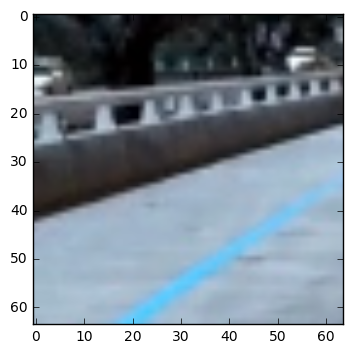

In [532]:
# test if the function works
img = preprocess(img1,windows3[1])
plt.imshow(img)

In [537]:
def features_from_img(img):
    # Create a list to append feature vectors to
    features_all = []
    
    for n in range(len(windows_all)):
        # Read in each one by one
        image_rgb = preprocess(img,windows_all[n])
        
        features = extract_features(image_rgb) # extract features
        
        features_all.append(features)
        
    # scale
    scaled_features = X_scaler.transform(features_all)
    # Return list of feature vectors
    return scaled_features

In [538]:
img_features = features_from_img(img1)

In [539]:
# prediction
pred = clf.predict_proba(img_features)[:,1]

In [571]:
# get windows with car images
def get_car_windows(pred):
    windows_car = []
    for n in range(len(pred)):
        if pred[n] > 0.52:
            windows_car.append(windows_all[n])
    return windows_car

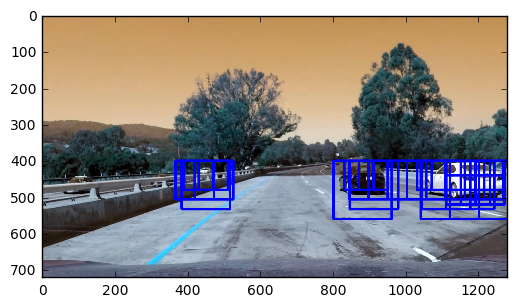

In [553]:
windows_car = get_car_windows(pred)

# plot the windows put on the images
img_box = draw_boxes(img1, windows_car, color=(0, 0, 255), thick=6)
plt.imshow(img_box)

In [554]:
def find_cars(img):
    # extract feature
    img_features = features_from_img(img)
    
    # prediction
    pred = clf.predict_proba(img_features)[:,1]
    
    # get windows with car images
    windows_car = get_car_windows(pred)
    
    return windows_car

### create bounding box

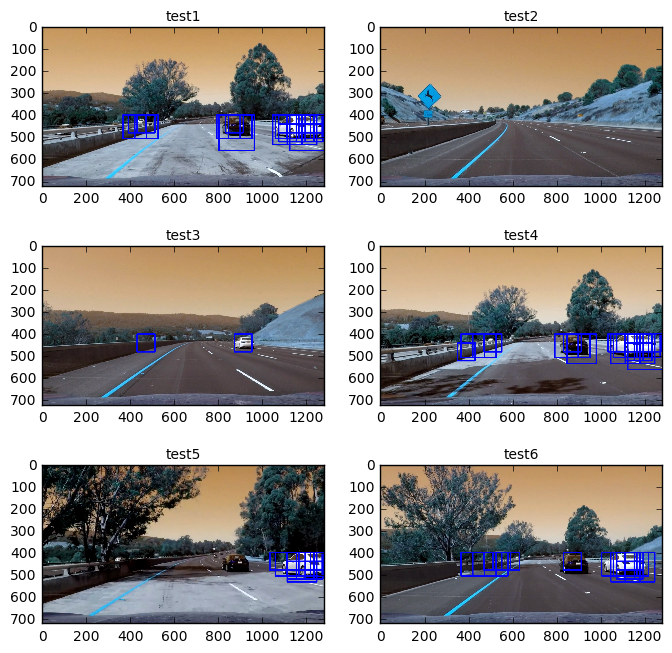

In [572]:
# all test images
windows_car = find_cars(img1)
img_box1 = draw_boxes(img1, windows_car, color=(0, 0, 255), thick=6)

windows_car = find_cars(img2)
img_box2 = draw_boxes(img2, windows_car, color=(0, 0, 255), thick=6)

windows_car = find_cars(img3)
img_box3 = draw_boxes(img3, windows_car, color=(0, 0, 255), thick=6)

windows_car = find_cars(img4)
img_box4 = draw_boxes(img4, windows_car, color=(0, 0, 255), thick=6)

windows_car = find_cars(img5)
img_box5 = draw_boxes(img5, windows_car, color=(0, 0, 255), thick=6)

windows_car = find_cars(img6)
img_box6 = draw_boxes(img6, windows_car, color=(0, 0, 255), thick=6)

f, ((ax1, ax2),(ax3, ax4),(ax5, ax6))= plt.subplots(3, 2, figsize=(8,8))
ax1.imshow(img_box1)
ax1.set_title('test1', fontsize=10)
ax2.imshow(img_box2)
ax2.set_title('test2', fontsize=10)
ax3.imshow(img_box3)
ax3.set_title('test3', fontsize=10)
ax4.imshow(img_box4)
ax4.set_title('test4', fontsize=10)
ax5.imshow(img_box5)
ax5.set_title('test5', fontsize=10)
ax6.imshow(img_box6)
ax6.set_title('test6', fontsize=10)

In [576]:
# create a heat map
def add_heat(heatmap, boxlist):
    # Iterate through list of bboxes
    for box in boxlist:
        # Add += 1 for all pixels inside each bbox
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1
    
    # Return updated heatmap
    return heatmap

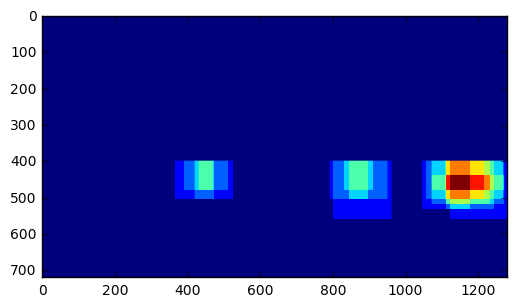

In [577]:
image = img1
bboxes = find_cars(image)

# inicalize heat map
heat = np.zeros_like(image[:,:,0]).astype(np.float)

heatmap = add_heat(heat, bboxes)
plt.imshow(heatmap)


In [634]:
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap < threshold] = 0
    # Return thresholded map
    return heatmap

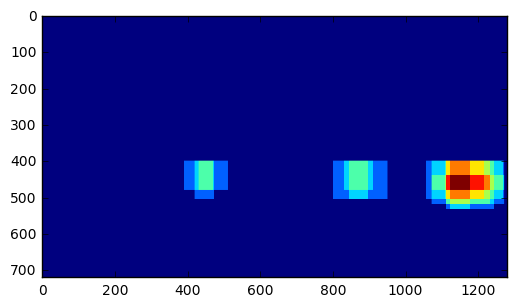

In [579]:
heatmap = apply_threshold(heatmap, 1)
plt.imshow(heatmap)


3 cars found


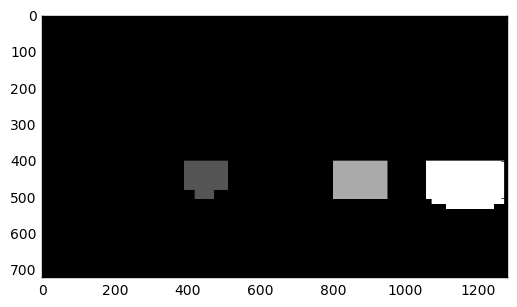

In [592]:
labels = label(heatmap)
print(labels[1], 'cars found')
plt.imshow(labels[0], cmap='gray')

In [581]:
def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    draw_img = np.copy(img)
    
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(draw_img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return draw_img

In [593]:
def find_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    draw_img = np.copy(img)
    bboxes = []
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        #cv2.rectangle(draw_img, bbox[0], bbox[1], (0,0,255), 6)
        bboxes.append(bbox)
    # Return the boxes
    #bboxes.append(bbox)
    return bboxes

In [594]:
bboxes = find_labeled_bboxes(image, labels)


In [595]:
bboxes

[((390, 400), (509, 505)),
 ((800, 400), (948, 505)),
 ((1055, 400), (1269, 532))]

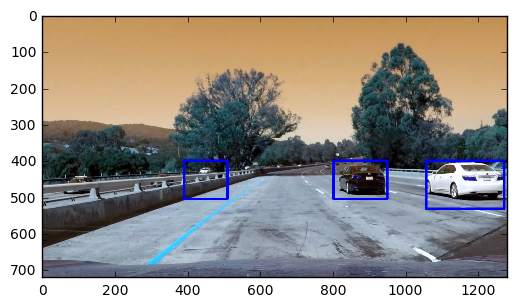

In [596]:
img_box = draw_boxes(img1, bboxes, color=(0, 0, 255), thick=6)
plt.imshow(img_box)

In [589]:
bboxes[0]

((1055, 400), (1269, 532))

In [461]:
def draw_bounding_box(image,bboxes):
    # inicalize heat map
    heat = np.zeros_like(image[:,:,0]).astype(np.float)
    heatmap = add_heat(heat, bboxes)
    #heatmap = apply_threshold(heatmap, 1)
    labels = label(heatmap)
    
    bboxes = find_labeled_bboxes(image, labels)
    
    image_draw = draw_labeled_bboxes(image, bboxes)

    return image_draw

In [627]:
def find_labes(image,boxes):
    heat = np.zeros_like(image[:,:,0]).astype(np.float)
    heatmap = add_heat(heat, boxes)
    heatmap = apply_threshold(heatmap, 1)
    labels = label(heatmap)
    return labels


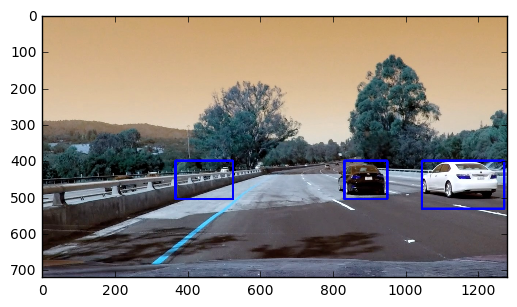

In [629]:
image = img4

boxes = find_cars(image)

labels = find_labes(image,boxes)

bounding_boxes = find_labeled_bboxes(image, labels)

img_box = draw_boxes(image, bounding_boxes, color=(0, 0, 255), thick=6)

plt.imshow(img_box)

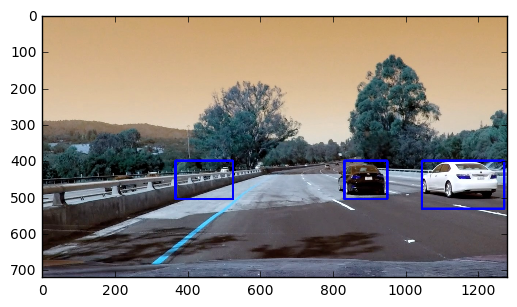

In [597]:
image = img4
boxes = find_cars(image)

heat = np.zeros_like(image[:,:,0]).astype(np.float)
heatmap = add_heat(heat, boxes)
heatmap = apply_threshold(heatmap, 1)
labels = label(heatmap)

bboxes = find_labeled_bboxes(image, labels)

img_box = draw_boxes(image, bboxes, color=(0, 0, 255), thick=6)

plt.imshow(img_box)

# tracking

In [695]:
class car():
    def __init__(self):
        # was the line detected in the last iteration?
        # x values of the last n fits of the line
        
        self.average_centroid= (0,0)
        #average x values of the fitted line over the last n iterations
        
        #average x values of the fitted line over the last n iterations
        
        self.average_size = (0,0)
        # define a function find near centroid
        
        self.detected = 0  # moving average
        

In [896]:
def track_car(cntrd,old_Cars):
    threshod_dist = 20
    Dist = []
    if old_Cars ==[]:
        car_found = False
        car_id = 0
        return car_found,car_id
    else:
        for car in old_Cars:
            dist = cal_dist(cntrd, car.average_centroid)
            Dist.append(dist)

        car_id = np.argmin(Dist)
        if Dist[car_id] < threshod_dist:
            car_found = True
        else:
            car_found = False
        return car_found, car_id

In [894]:
# caculate distance
def cal_dist(centroid1, centroid2):
    x1 = centroid1[0]
    y1 = centroid1[1]
    x2 = centroid2[0]
    y2 = centroid2[1]
    
    return np.sqrt((x1-x2)**2 + (y1-y2)**2)


In [639]:
# test the function
centroid1 = (1,2)
centroid2 = (2,5)
dist = cal_dist(centroid1, centroid2)
print(dist)

3.16227766017


## Video pipline

In [829]:
class car():
    def __init__(self):
            # was the line detected in the last iteration?
            # x values of the last n fits of the line

            self.average_centroid= (0,0)
            #average x values of the fitted line over the last n iterations

            #average x values of the fitted line over the last n iterations

            #self.average_size = (0,0)
            self.width = 0
            
            self.height = 0
            # define a function find near centroid

            self.detected = 0  # moving average

In [887]:
Old_Cars

[]

In [850]:
New_Cars

In [926]:
# video pipline
global Old_Cars 
#Old_Cars = []

def process_img(image):
    class car():
        def __init__(self):
                # was the line detected in the last iteration?
                # x values of the last n fits of the line

                self.average_centroid= (0,0)
                #average x values of the fitted line over the last n iterations

                #average x values of the fitted line over the last n iterations

                #self.average_size = (0,0)
                self.width = 0

                self.height = 0
                # define a function find near centroid

                self.detected = 0  # moving average
    
    global Old_Cars
    
    # Here are the bounding boxes I used
    draw_img = np.copy(image)
    
    boxes = find_cars(image)
    
    labels = find_labes(image,boxes)

    bounding_boxes = find_labeled_bboxes(image, labels)
    
    draw_img = draw_boxes(draw_img, bounding_boxes, color=(0, 0, 255), thick=3)
        
    bboxes = bounding_boxes
    centroids = []
    box_size = []
    
    for box in bboxes:
        x = int((box[0][0] + box[1][0])/2)
        y = int((box[0][1] + box[1][1])/2)
        centroids.append((x,y))

        width =  int((box[1][0] - box[0][0])/2)
        height = int((box[1][1] - box[0][1])/2)
        box_size.append((width,height))

   
    New_Cars = []
    for n in range(len(centroids)):
        # find the nearest car
        car_found, k = track_car(centroids[n],Old_Cars) # return a number 
        #print(car_found)
        if car_found  == True:
            old_car = Old_Cars[k]
            old_car.average_centroid = (int(0.7*old_car.average_centroid[0] + 0.3*centroids[n][0]),
                                    int(0.7*old_car.average_centroid[1] + 0.3*centroids[n][1]))
            
            old_car.width =   int(0.9*old_car.width + 0.1*box_size[n][0])
            old_car.height =  int(0.9*old_car.height + 0.1*box_size[n][1])
            
            old_car.detected = old_car.detected*0.5 + 0.5
            New_Cars.append(old_car)        

        else:
            new_car = car()
            new_car.recent_centroid = centroids[n]
            new_car.average_centroid = centroids[n]
            new_car.width =  box_size[n][0]
            new_car.height = box_size[n][1]
            
            new_car.detected = 0.5
            New_Cars.append(new_car)

    #print(New_Cars)
    box2 = []
    for car2 in New_Cars:
        if car2.detected > 0.6:
            offset = car2.average_centroid
            
            width = car2.width
            height = car2.height
            
            
            bbox0 = (int(-width+offset[0]),
                     int(-height+offset[1]))
            bbox1 = (int(width+offset[0]),
                     int(height+offset[1]))
            
            box2.append((bbox0,bbox1))

    draw_img = draw_boxes(draw_img, box2, color=(255, 0, 0), thick=3)
    
    Old_Cars2 = Old_Cars
    Old_Cars = New_Cars # new + detected
    # update car list
    for car in Old_Cars2:
        car.detected = car.detected*0.5 # fade old value
        if car.detected > 0.1:    
            Old_Cars.append(car)
    
    
    return draw_img

In [927]:
len(Old_Cars)

3

In [925]:
Old_Cars[2].detected

0.0732421875

[<__main__.process_img.<locals>.car at 0x6bd657908>,
 <__main__.process_img.<locals>.car at 0x6bd6627f0>,
 <__main__.process_img.<locals>.car at 0x6c8423eb8>,
 <__main__.process_img.<locals>.car at 0x6bd657908>,
 <__main__.process_img.<locals>.car at 0x6bd6627f0>,
 <__main__.process_img.<locals>.car at 0x6c8423eb8>,
 <__main__.process_img.<locals>.car at 0x6bd657748>,
 <__main__.process_img.<locals>.car at 0x6bd657748>,
 <__main__.process_img.<locals>.car at 0x6bd657748>,
 <__main__.process_img.<locals>.car at 0x6bd657860>,
 <__main__.process_img.<locals>.car at 0x6caa2f668>,
 <__main__.process_img.<locals>.car at 0x6bd657860>,
 <__main__.process_img.<locals>.car at 0x6bd662f60>,
 <__main__.process_img.<locals>.car at 0x6bd657860>,
 <__main__.process_img.<locals>.car at 0x6bd662f60>,
 <__main__.process_img.<locals>.car at 0x6bd662f60>,
 <__main__.process_img.<locals>.car at 0x6c6bb2748>,
 <__main__.process_img.<locals>.car at 0x6c6bb2748>,
 <__main__.process_img.<locals>.car at 0x6c6bb

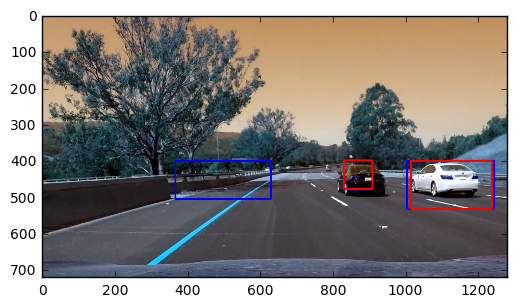

In [918]:
img_dr =process_img(img6)
plt.imshow(img_dr)
Old_Cars

In [928]:
#process on a video
global Old_Cars
Old_Cars = []
white_output = 'project_video_after.mp4'
clip1 = VideoFileClip("/Users/daruizhang/Documents/CarND_P4_Video/project_video.mp4")
#clip1 = VideoFileClip("/Users/daruizhang/Documents/CarND_P4_Video/challenge_video.mp4")
#clip1 = VideoFileClip("/Users/daruizhang/Documents/CarND_P4_Video/harder_challenge_video.mp4")

white_clip = clip1.fl_image(process_img) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video project_video_after.mp4
[MoviePy] Writing video project_video_after.mp4
























  0%|          | 0/1261 [00:00<?, ?it/s]





















  0%|          | 1/1261 [00:00<07:47,  2.70it/s]





















  0%|          | 2/1261 [00:00<07:23,  2.84it/s]





















  0%|          | 3/1261 [00:00<06:44,  3.11it/s]





















  0%|          | 4/1261 [00:01<06:14,  3.36it/s]





















  0%|          | 5/1261 [00:01<05:54,  3.54it/s]





















  0%|          | 6/1261 [00:01<06:19,  3.31it/s]





















  1%|          | 7/1261 [00:02<05:55,  3.53it/s]





















  1%|          | 8/1261 [00:02<05:43,  3.65it/s]





















  1%|          | 9/1261 [00:02<05:57,  3.50it/s]





















  1%|          | 10/1261 [00:02<06:03,  3.44it/s]





















  1%|          | 11/1261 [00:03<05:56,  3.50it/s]





















  1%|          | 12/1261 [00:03<05:52,  3.54it/s]





















  1%|          | 13/1261 [00:03<05:53,  3.53it/s]





















  

[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_after.mp4 

CPU times: user 5min 46s, sys: 9.23 s, total: 5min 55s
Wall time: 7min 12s


In [929]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))